# LFC test

In [1]:
import metpy.calc as calc
import metpy._calc_mod as calc_mod
from metpy.units import units
import numpy as np
import pandas as pd
from metpy.cbook import get_test_data
import matplotlib.pyplot as plt
from metpy.plots import SkewT

## get example sounding data

In [2]:
col_names = ['pressure', 'height', 'temperature', 'dewpoint', 'direction', 'speed']

df = pd.read_fwf(get_test_data('20110522_OUN_12Z.txt', as_file_obj=False),
                 skiprows=7, usecols=[0, 1, 2, 3, 6, 7], names=col_names)

# Drop any rows with all NaN values for T, Td, winds
df = df.dropna(subset=('temperature', 'dewpoint', 'direction', 'speed'),
               how='all').reset_index(drop=True)

In [3]:
p = df['pressure'].values * units.hPa
T = df['temperature'].values * units.degC
Td = df['dewpoint'].values * units.degC
p, T, Td, par_prof = calc.parcel_profile_with_lcl(p, T, Td)

In [4]:
p

Magnitude,[966.0 953.0 948.9969276195382 936.9 925.0 904.5 896.0 890.0 886.0 873.3 873.0 850.0 846.0 813.8 802.0 785.0 757.1 730.1 700.0 653.3 639.0 606.0 605.6 584.0 582.7 582.0 577.0 571.0 561.0 560.7 539.4 539.0 500.0 478.9 453.0 443.0 406.3 400.0 389.3 327.3 313.4 300.0 286.0 250.0 249.0 220.0 210.0 200.0 197.0 196.5 190.0 181.0 173.0 159.0 155.0 154.2 150.0 148.0 146.9 146.0 142.0 140.0 137.0 133.3 127.0 126.0 120.9 111.0 109.0 104.0 100.0]
Units,hectopascal


In [5]:
T

Magnitude,[22.2 21.4 21.250817178367882 20.8 20.4 19.3 18.8 20.0 22.2 23.2 23.2 22.0 21.8 19.2 18.2 16.5 13.7 10.9 7.6 2.3 0.6 -2.9 -2.9 -4.5 -4.4 -4.3 -3.7 -3.3 -3.9 -3.9 -6.3 -6.3 -11.1 -13.7 -17.1 -18.3 -23.9 -24.9 -26.6 -37.9 -40.7 -43.5 -46.3 -52.1 -52.3 -54.1 -55.9 -56.5 -56.5 -56.5 -56.5 -57.9 -56.9 -59.3 -58.9 -59.0 -59.5 -59.9 -59.2 -58.7 -57.9 -56.7 -56.5 -57.7 -59.8 -60.1 -61.0 -62.9 -64.3 -63.3 -64.3]
Units,degree_Celsius


In [6]:
Td

Magnitude,[21.0 20.7 20.650272392789294 20.5 20.4 19.3 18.8 20.0 19.0 13.3 13.2 6.0 3.8 -1.7 -3.8 -4.7 -6.2 -7.7 -9.4 -10.9 -11.4 -12.9 -12.9 -14.5 -14.4 -14.3 -24.7 -36.3 -31.9 -31.8 -27.4 -27.3 -29.1 -31.3 -34.1 -32.3 -37.0 -37.9 -39.3 -48.1 -50.3 -52.5 -55.3 -62.1 -62.3 -64.1 -65.9 -66.5 -66.5 -66.5 -66.5 -67.9 -66.9 -69.3 -68.9 -69.0 -69.5 -69.9 -69.2 -68.7 -67.9 -66.7 -66.5 -67.7 -69.8 -70.1 -71.0 -72.9 -73.3 -73.3 -74.3]
Units,degree_Celsius


## Sounding Plot

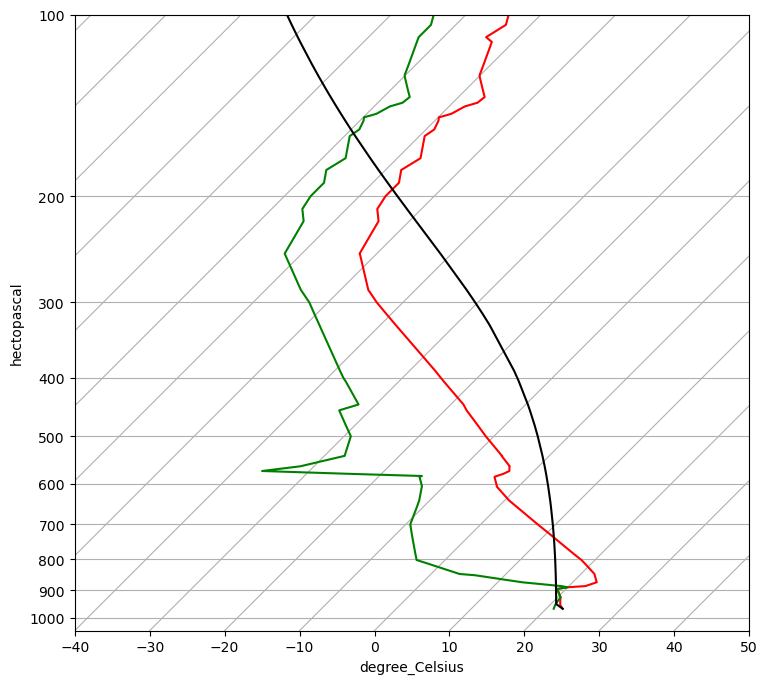

In [7]:
fig = plt.figure(figsize=(10, 8))
skew = SkewT(fig, rotation=45)

skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.plot(p, par_prof.to('degC'), 'k')
plt.show()

In [8]:
# set a typical iteration number
iteration = 200*200  # typical value for data with 200*200 horizontal resolution

## Original python version

#### parcel temperature profile not provided as input

In [9]:
%%time

for i in range(iteration):
    result = calc.lfc(p, T, Td)

print("LFC: ", result[0], "   ",result[1])

LFC:  735.8379204946915 hectopascal     11.503610919227933 degree_Celsius
CPU times: user 1min 47s, sys: 667 ms, total: 1min 47s
Wall time: 1min 47s


#### parcel temperature profile provided as input

In [10]:
%%time

for i in range(iteration):
    result = calc.lfc(p, T, Td, par_prof)

print("LFC: ", result[0], "   ",result[1])

LFC:  735.8379204946915 hectopascal     284.6536109192279 kelvin
CPU times: user 9.08 s, sys: 1.81 ms, total: 9.08 s
Wall time: 9.08 s


## Underlying c++ version

#### parcel temperature profile not provided as input

In [11]:
%%time

for i in range(iteration):
    result = calc.lfc_linfel(p, T, Td)

print("LFC: ", result[0], "   ",result[1])

LFC:  735.8381146984954 hectopascal     11.503631269088435 degree_Celsius
CPU times: user 55 s, sys: 649 ms, total: 55.6 s
Wall time: 55.1 s


#### parcel temperature profile provided as input

In [12]:
%%time

for i in range(iteration):
    result = calc.lfc_linfel(p, T, Td, par_prof)

print("LFC: ", result[0], "   ",result[1])

LFC:  735.8379204946915 hectopascal     284.6536109192279 kelvin
CPU times: user 8.56 s, sys: 2.73 ms, total: 8.56 s
Wall time: 8.58 s


### This also indicated that the step of building a parcel temperature profile is the rate-determining step.